# (SDSS) Predicting interstellar object types using photometric measurements

In astronomy, stellar classification is the classification of stars based on their spectral characteristics. The classification scheme of galaxies, quasars, and stars is one of the most fundamental in astronomy. The early cataloguing of stars and their distribution in the sky has led to the understanding that they make up our own galaxy and, following the distinction that Andromeda was a separate galaxy to our own, numerous galaxies began to be surveyed as more powerful telescopes were built. This datasat aims to classificate stars, galaxies, and quasars based on their spectral characteristics.

The data consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar.

1. obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
2. alpha = Right Ascension angle (at J2000 epoch)
3. delta = Declination angle (at J2000 epoch)
4. u = Ultraviolet filter in the photometric system
5. g = Green filter in the photometric system
6. r = Red filter in the photometric system
7. i = Near Infrared filter in the photometric system
8. z = Infrared filter in the photometric system
9. run_ID = Run Number used to identify the specific scan
10. rereun_ID = Rerun Number to specify how the image was processed
11. cam_col = Camera column to identify the scanline within the run
12. field_ID = Field number to identify each field
13. spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14. class = object class (galaxy, star or quasar object)
15. redshift = redshift value based on the increase in wavelength
16. plate = plate ID, identifies each plate in SDSS
17. MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18. fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

source: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17?datasetId=1866141&sortBy=voteCount

## 1. Importing Pandas and getting a glimpse of the data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
import random
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# import data from kaggle to the directory we are working in
# read data from directory and print first 5 objects (head)
star_classification = pd.read_csv("star_classification.csv")
# we have 100,000 observations and values for all variables which is great
star_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
obj_ID         100000 non-null float64
alpha          100000 non-null float64
delta          100000 non-null float64
u              100000 non-null float64
g              100000 non-null float64
r              100000 non-null float64
i              100000 non-null float64
z              100000 non-null float64
run_ID         100000 non-null int64
rerun_ID       100000 non-null int64
cam_col        100000 non-null int64
field_ID       100000 non-null int64
spec_obj_ID    100000 non-null float64
class          100000 non-null object
redshift       100000 non-null float64
plate          100000 non-null int64
MJD            100000 non-null int64
fiber_ID       100000 non-null int64
dtypes: float64(10), int64(7), object(1)
memory usage: 13.7+ MB


In [4]:
# look at the distribution of values in the dataset
star_classification.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


We notice outliers for the u, z and g filters with values of -9999 which should not be allowed (cannot have negative values) so we select this outlier and drop that row from the dataset.

In [5]:
# select the row with u or z or g below 0 (should not be allowed)
outliers = star_classification[(star_classification["u"] <= 0)  
                               | (star_classification["z"] <= 0) 
                               | (star_classification["g"] <= 0)]
outliers
# we notice that it is only one object which was classified as a star

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
79543,1.237649e+18,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,752,301,2,537,3.731277e+18,STAR,0.000089,3314,54970,162


In [6]:
# drop the row corresponding to the outlier
star_classification = star_classification.drop(outliers.index, axis=0)
# check that we indeed got rid of one row - yes, from 100,000 to 99,999
star_classification.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99999
Data columns (total 18 columns):
obj_ID         99999 non-null float64
alpha          99999 non-null float64
delta          99999 non-null float64
u              99999 non-null float64
g              99999 non-null float64
r              99999 non-null float64
i              99999 non-null float64
z              99999 non-null float64
run_ID         99999 non-null int64
rerun_ID       99999 non-null int64
cam_col        99999 non-null int64
field_ID       99999 non-null int64
spec_obj_ID    99999 non-null float64
class          99999 non-null object
redshift       99999 non-null float64
plate          99999 non-null int64
MJD            99999 non-null int64
fiber_ID       99999 non-null int64
dtypes: float64(10), int64(7), object(1)
memory usage: 14.5+ MB


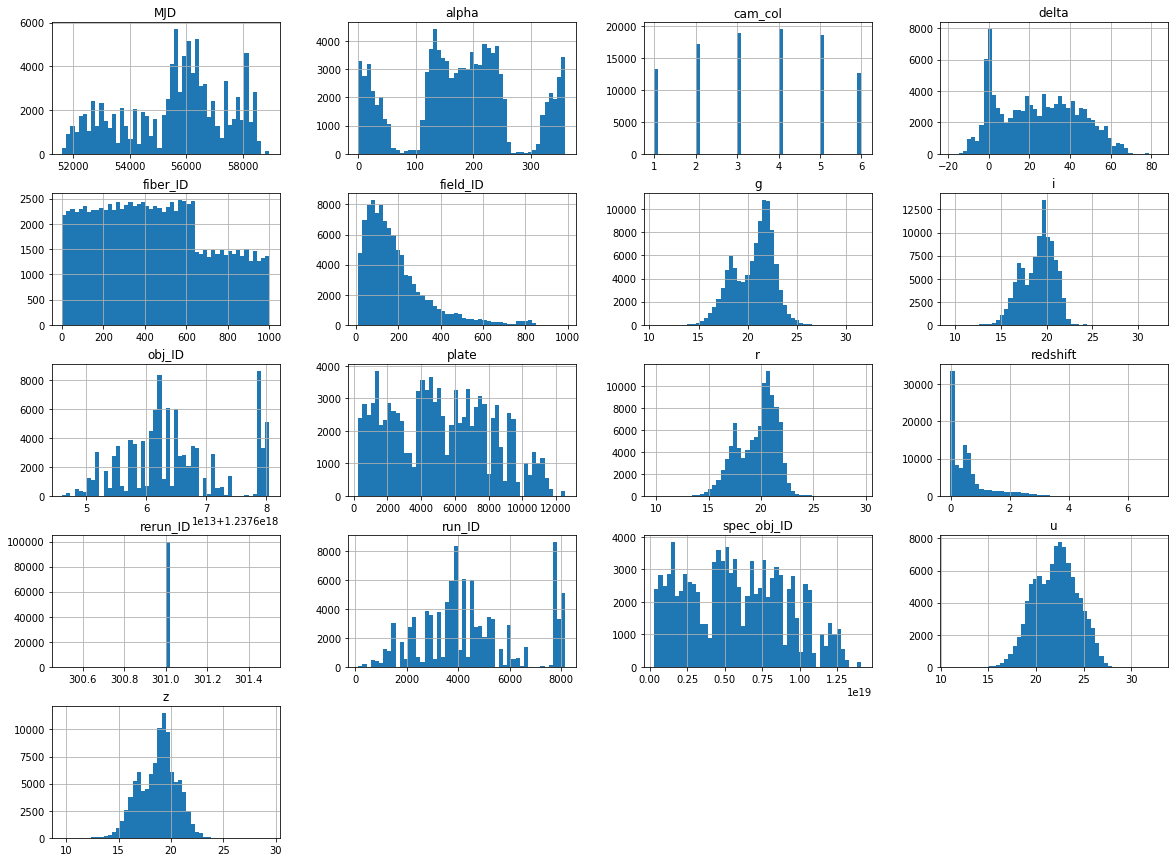

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
# plotting histograms for each column to analyse distribution of data points
star_classification.hist(bins=50, figsize=(20,15))
plt.show()

Let's now create training and testing sets by keeping the spread of categories we have in the overall dataset (see star_classification["class"].value_counts() above).

## 2. Creating training and test sets (stratified train/tes split)

We aim at keeping the same distribution in training and testing sets as we have in the overall dataset. We choose a test size of 20% of the dataset.

GALAXY    59445
STAR      21593
QSO       18961
Name: class, dtype: int64

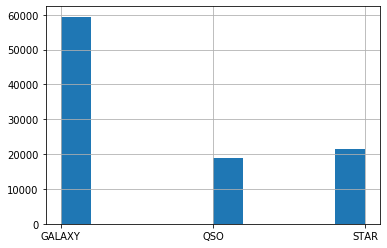

In [8]:
# histogram of different classes
star_classification["class"].hist()
# not an even spread between the different categories, will need to take into account!
star_classification["class"].value_counts()

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(star_classification, star_classification["class"]):
    strat_train_set = star_classification.loc[train_index]
    strat_test_set = star_classification.loc[test_index]

# will indicate the proportion of districts in each category
strat_test_set["class"].value_counts() / len(strat_test_set)

C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """


GALAXY    0.59795
STAR      0.21430
QSO       0.18775
Name: class, dtype: float64

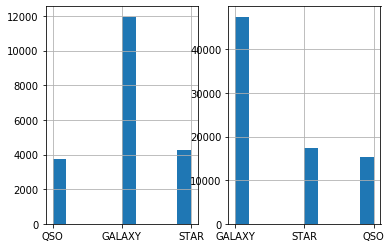

In [10]:
# make sure we keep the same distribution
plt.subplot(1,2,1)
strat_test_set["class"].hist()
plt.subplot(1,2,2)
strat_train_set["class"].hist()

plt.show()

## 3. Manipulating the data

We make a copy of the data set so that we can manipulate it freely and delete any useless information.

In [11]:
# create a copy of the training set to manipulate without harming original
star_classification = strat_train_set.copy()
# we drop the data we are not interested in and which won't be useful
star_classification = star_classification.drop(
    columns=["obj_ID", "fiber_ID", "MJD", "plate", "spec_obj_ID", 
             "field_ID", "cam_col", "rerun_ID", "run_ID"], axis=1)
star_classification

,alpha,delta,u,g,r,i,z,class,redshift
31871,236.886133,25.746372,24.00161,21.22490,19.42473,18.74697,18.36518,GALAXY,0.388266
5421,175.396226,7.414312,18.64321,16.61261,15.60582,15.17248,14.78776,GALAXY,0.088187
81867,330.310510,22.865798,24.78542,24.65894,21.96032,20.77460,19.91515,GALAXY,0.685564
88632,184.534708,6.293682,19.19104,18.05456,17.65642,17.38591,17.28063,GALAXY,0.078282
16810,132.807587,26.488426,23.82002,21.94656,20.20684,19.42892,18.98755,GALAXY,0.431886
...,...,...,...,...,...,...,...,...,...
71002,18.750721,17.875593,24.16069,24.06798,22.36660,20.86997,19.84217,GALAXY,1.414617
84487,217.441998,18.175481,19.19778,17.79148,17.14975,16.81536,16.50878,GALAXY,0.087129
30475,162.331002,40.079474,24.74782,21.97550,20.49869,19.49992,18.99151,GALAXY,0.522292
52498,232.201919,18.045794,18.97042,17.60048,16.88147,16.45545,16.13567,GALAXY,0.085534


In [12]:
# selecting all objects that are labelled as galaxies/stars/QSOs
df_galaxy = star_classification[star_classification["class"] == "GALAXY"]
df_star = star_classification[star_classification["class"] == "STAR"]
df_QSO = star_classification[star_classification["class"] == "QSO"]

array(['GALAXY', 'STAR', 'QSO', nan], dtype=object)

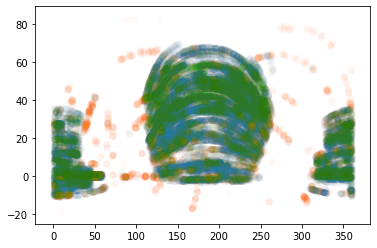

In [14]:
# for each class, select the data and plot it -> allows for different coloured data points
# plot the positions in the sky (right ascension and declination)
for name in star_classification["class"].unique():
    df_temp = star_classification[star_classification["class"] == name]
    plt.scatter(df_temp.alpha.values, df_temp.delta.values, alpha=0.01)

# shows all the unique categories in the "class" column
star_classification["class"].unique()

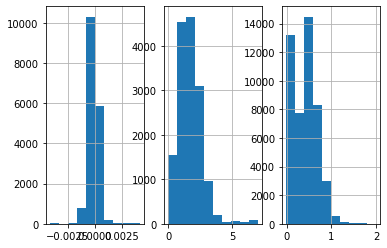

In [16]:
plt.subplot(1,3,1)
df_star["redshift"].hist()
plt.subplot(1,3,2)
df_QSO["redshift"].hist()
plt.subplot(1,3,3)
df_galaxy["redshift"].hist()

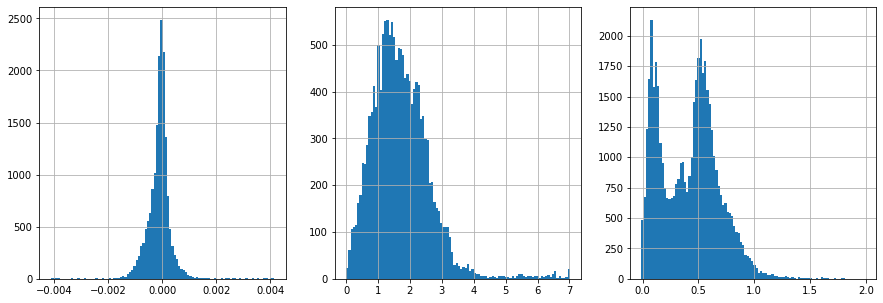

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.subplot(1,3,1)
df_star["redshift"].hist(bins=100)
plt.subplot(1,3,2)
df_QSO["redshift"].hist(bins=100)
plt.subplot(1,3,3)
df_galaxy["redshift"].hist(bins=100)

NaN values which we will need to get rid of later on.

## Visualising the dataset

Try combination of attributes and features to analyse if any combination leads to a clear seperation of classes.